In [15]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import dask
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import fsspec
import requests
import aiohttp
import nc_time_axis
import cftime
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [17]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2' & experiment_id =='abrupt-4xCO2'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[-1]), consolidated=True)
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])

In [18]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_tas_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR'")

# df_ta_ncar.experiment_id.unique()
df_tas_ncar

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
53470,CMIP,NCAR,CESM2,amip,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/amip/r1i1p1f1...,NaN,20190218
55166,CMIP,NCAR,CESM2,amip,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/amip/r3i1p1f1...,NaN,20190220
55264,CMIP,NCAR,CESM2,amip,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/amip/r2i1p1f1...,NaN,20190220
59875,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
61655,CMIP,NCAR,CESM2,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...,NaN,20190308
61862,CMIP,NCAR,CESM2,historical,r5i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
62691,CMIP,NCAR,CESM2,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r2...,NaN,20190308
63131,CMIP,NCAR,CESM2,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
63266,CMIP,NCAR,CESM2,historical,r6i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308
64615,CMIP,NCAR,CESM2,historical,r8i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r8...,NaN,20190311


In [19]:
# df_ta_ncar = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2' & variable_id == 'tas'  & institution_id == 'NCAR'")
df_tas_ncar_his = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'tas' & institution_id == 'NCAR' & experiment_id == 'abrupt-4xCO2'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_tas_ncar_his.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_tas_his = xr.open_zarr(mapper_his, consolidated=True)
ds_tas_his

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/tas/gn/v20190927/


<xarray.Dataset>
Dimensions:    (lat: 192, nbnd: 2, lon: 288, time: 11988)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 0001-01-15 12:00:00 ... 0999-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(11988, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(823, 192, 288), meta=np.ndarray>
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          hybrid
    branch_time_in_child:   -182500.0
    branch_time_in_parent:  182865.0
    case_id:                46
    ...                     ...
    tracking_id:            hdl:21.14100/81280768-5338-4e76-a8cc-478d15b08664...
    variable_id:            tas
    variant_info:           CMIP6 CESM2 abrupt4xCO2 experiment with CAM6, int...
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/81280768-5338-4e76-a8cc-478d15b08664...
    version_id:             v20190927

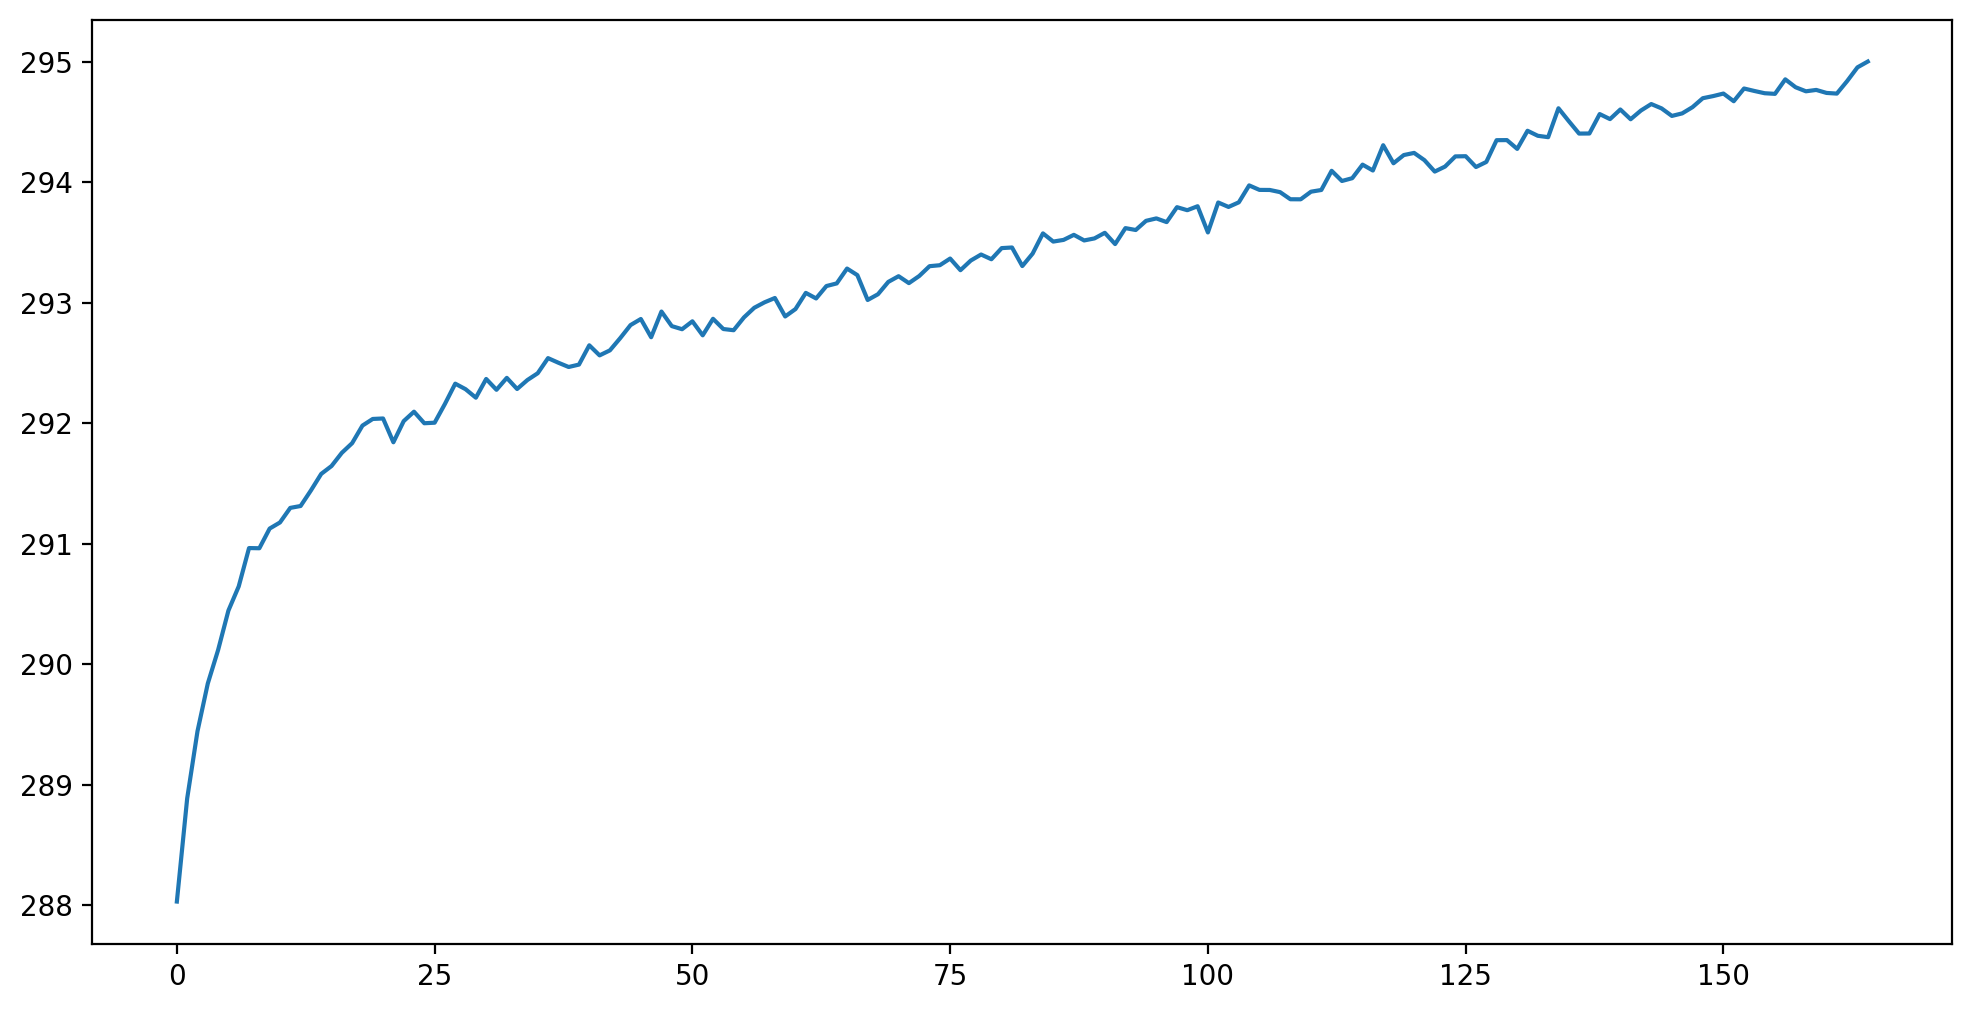

In [20]:
date_threshold = cftime.DatetimeNoLeap(166, 1, 1)
ds_tas_his_plt = ds_tas_his.where(ds_tas_his.time < date_threshold, drop=True)
tas_timeseries_his = (ds_tas_his_plt.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
array_tas_ts = np.array(tas_timeseries_his)
year_tas_ts = np.mean(array_tas_ts.reshape(len(array_tas_ts) // 12, 12), axis=1)
plt.plot(year_tas_ts)
plt.show()

In [21]:
df_co2ms_ncar_4x = df.query("activity_id=='CMIP' & table_id == 'Amon' &  source_id == 'CESM2'  & variable_id == 'co2mass' & institution_id == 'NCAR' & experiment_id == 'abrupt-4xCO2'")

# get the path to a specific zarr store (the first one from the dataframe above)
zstore_his = df_co2ms_ncar_4x.zstore.values[-1]
print(zstore_his)

# create a mutable-mapping-style interface to the store
mapper_his = fsspec.get_mapper(zstore_his)

# open it using xarray and zarr
ds_co2ms_his = xr.open_zarr(mapper_his, consolidated=True)
date_threshold = cftime.DatetimeNoLeap(166, 1, 1)
ds_co2ms_his_plt = ds_co2ms_his.where(ds_co2ms_his.time < date_threshold, drop=True)
ds_co2ms_his_plt

gs://cmip6/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/co2mass/gn/v20190927/


<xarray.Dataset>
Dimensions:    (time: 1980, nbnd: 2)
Coordinates:
  * time       (time) object 0001-01-15 12:00:00 ... 0165-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    co2mass    (time) float32 dask.array<chunksize=(1980,), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          hybrid
    branch_time_in_child:   -182500.0
    branch_time_in_parent:  182865.0
    case_id:                46
    ...                     ...
    tracking_id:            hdl:21.14100/f5ebc3dd-ccbd-442e-bfc9-11af489c2fe4...
    variable_id:            co2mass
    variant_info:           CMIP6 CESM2 abrupt4xCO2 experiment with CAM6, int...
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/f5ebc3dd-ccbd-442e-bfc9-11af489c2fe4...
    version_id:             v20190927

In [22]:
array_co2ms_ts = np.array(ds_co2ms_his_plt.co2mass)
year_co2ms_ts = np.mean(array_co2ms_ts.reshape(len(array_co2ms_ts) // 12, 12), axis=1)

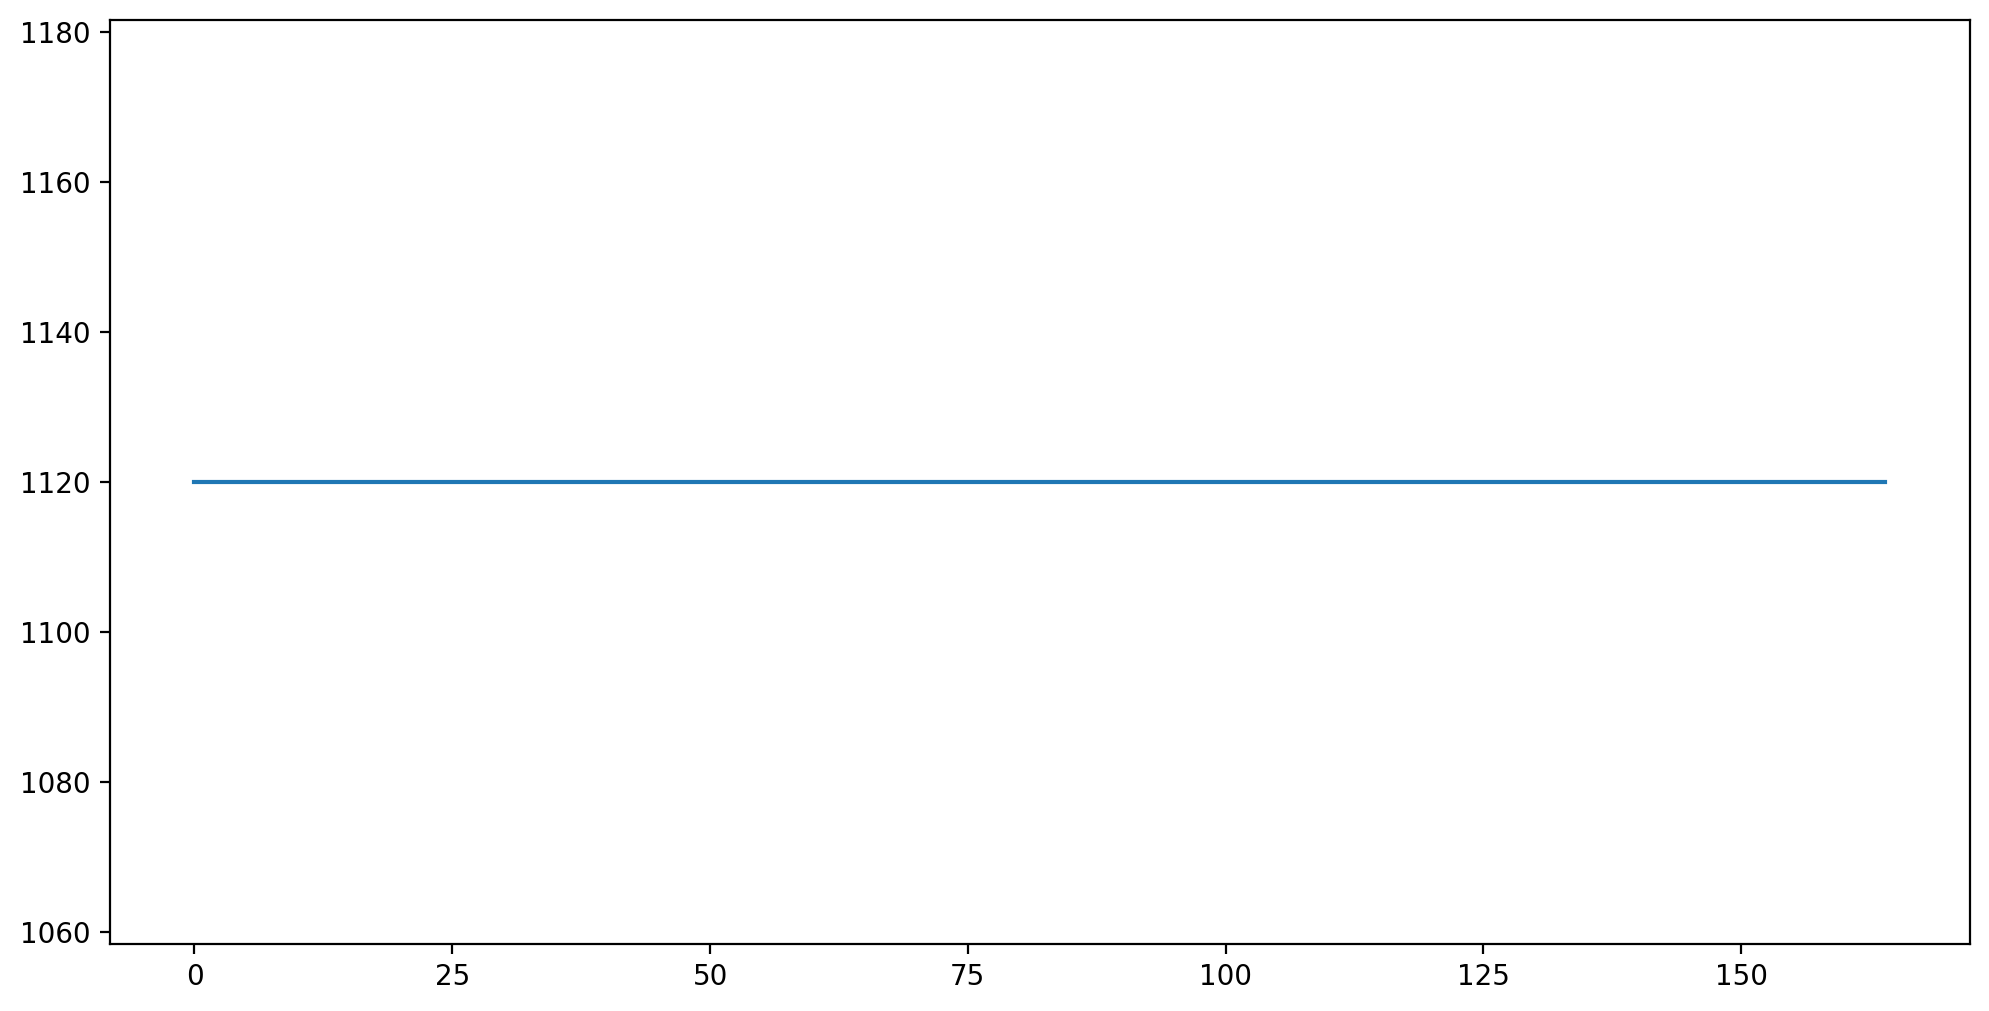

In [23]:
# init_1xco2 = 2226581800000000.0
conc_after = 4 * 280 / (1 + 3 * 1e-6)
year_co2_ts = np.full(len(year_co2ms_ts), conc_after)
plt.plot(year_co2_ts)
plt.show()

Optimized C (heat capacity): 11.32
Optimized alpha (feedback parameter): 0.46
Optimized eps (radiative forcing coefficient): 2.03
alpha over C 0.040961283883153586
eps over C 0.17938894183476806


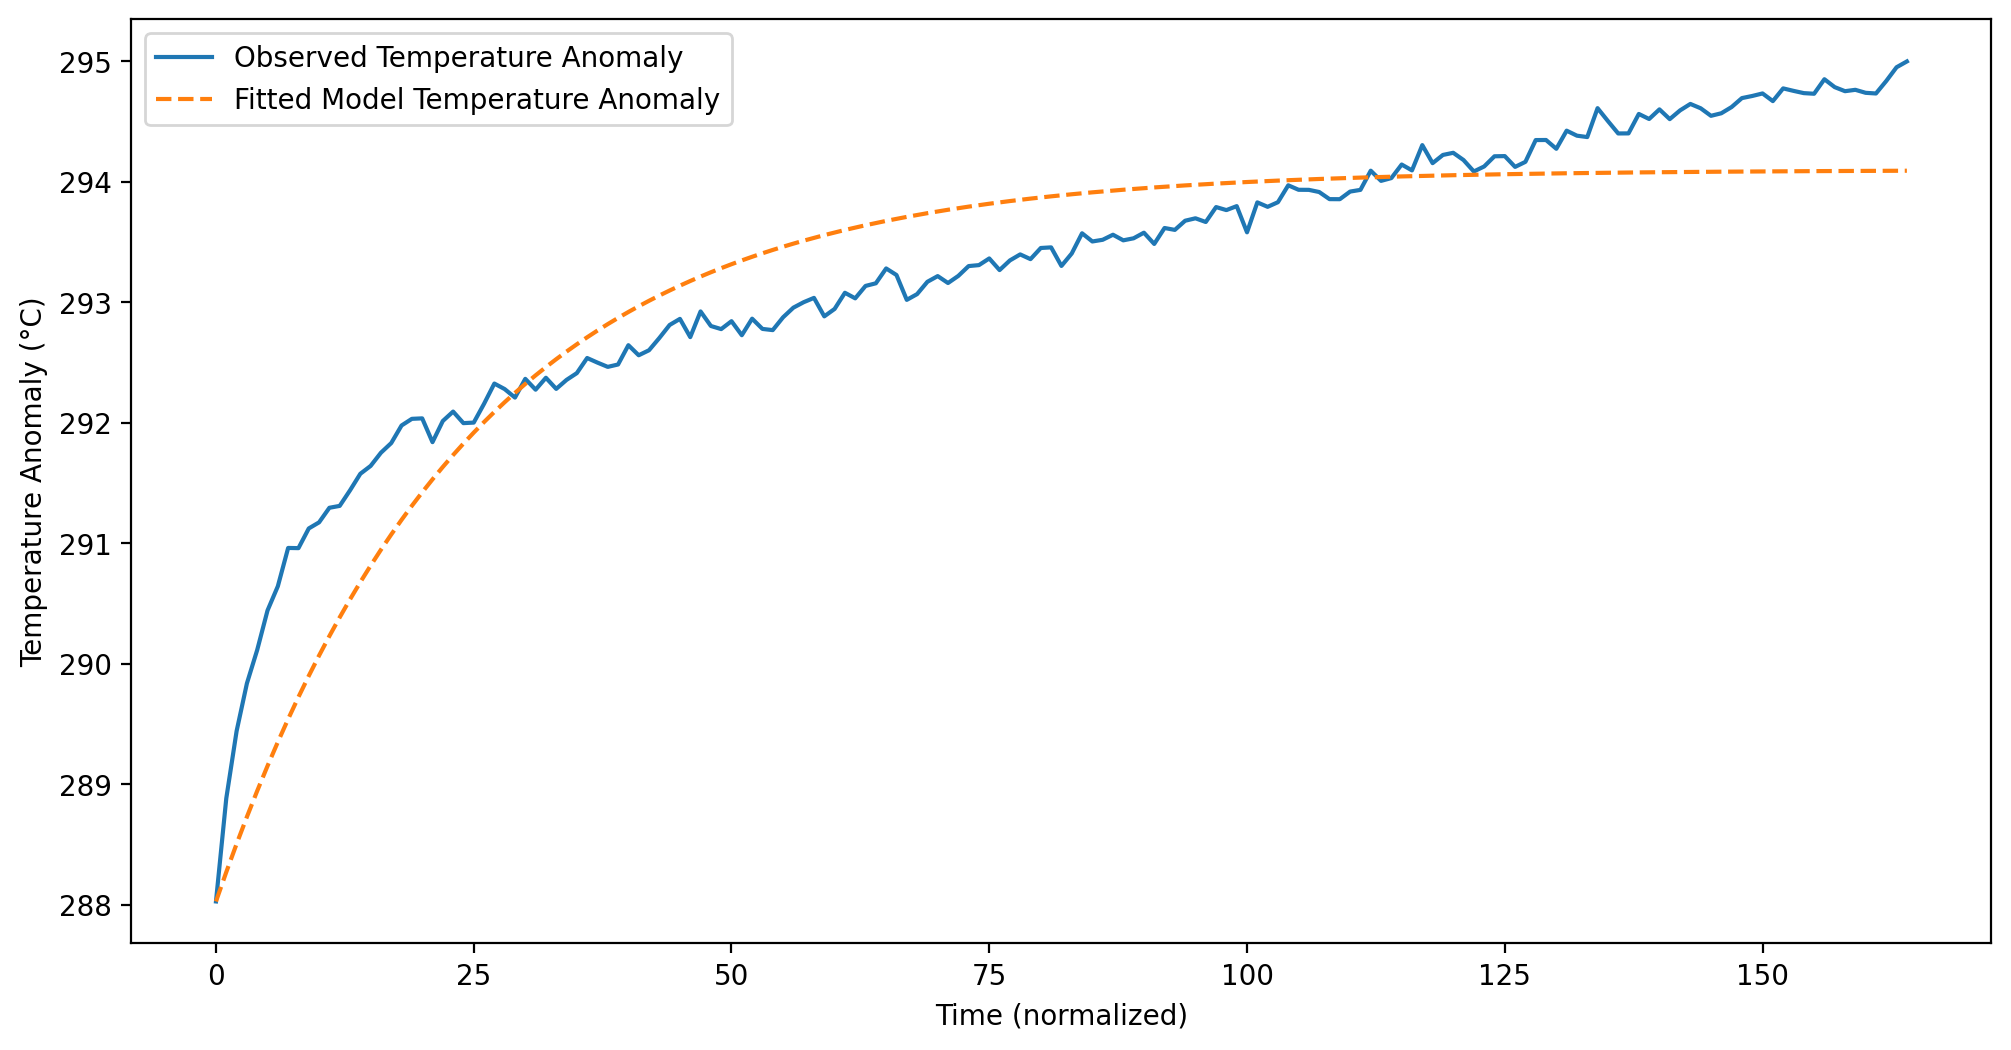

In [24]:
# Modified empirical function to calculate radiative forcing with parameter alpha
def calculate_forcing(C, alpha, C0=280):
    return alpha * np.log(C / C0)

# Interpolation function for CO2 data to handle non-integer time values
def get_interpolated_co2(t, co2_data):
    time_indices = np.arange(len(co2_data))
    co2_interp_func = interp1d(time_indices, co2_data, fill_value="extrapolate")
    return co2_interp_func(t)

# Differential equation model for global warming
def climate_model(T, t, C, alpha_param, emp_cst, forcing_func, co2_data):
    # Ensure that we get interpolated CO2 concentration if t is fractional
    co2_concentration = get_interpolated_co2(t, co2_data)
    G = forcing_func(co2_concentration, emp_cst)  # Calculate forcing based on interpolated CO2 and alpha
    dTdt = (G - alpha_param * T) / C
    return dTdt

# Objective function for optimization with alpha as an additional parameter
def objective_function(params, t, T_obs, co2_data):
    C, lambda_param, alpha = params
    T0 = T_obs[0]  # Initial temperature anomaly

    # Solve the differential equation with the provided parameters
    T_model = odeint(climate_model, T0, t, args=(C, lambda_param, alpha, calculate_forcing, co2_data)).flatten()
    
    # Calculate the mean squared error between model and observed data
    mse = np.mean((T_model - T_obs) ** 2)
    return mse

# Example data setup (replace this with actual time series data)
# t: time in years, co2_data: CO2 concentration in ppm, T_obs: observed temperature anomaly
time_shre = 0
co2_data = year_co2_ts.copy()[time_shre:]
T_obs = year_tas_ts.copy()[time_shre:] - year_tas_ts[0]
t = np.linspace(0, len(co2_data) - 1, len(co2_data))  # Time in years

# Initial parameter guesses for C, lambda, and alpha
initial_params = [8, 2, 6]  # Initial guesses for heat capacity, feedback parameter, and alpha

# Add bounds to keep parameters in realistic ranges
bounds = [(1, 100), (0.1, 2), (4, 6)]  # Realistic bounds for C, lambda, and alpha

# Perform optimization to find the best-fit parameters
result = minimize(objective_function, initial_params, args=(t, T_obs, co2_data), method='L-BFGS-B')

# Extract optimized parameters
C_opt, alpha_opt, eps_opt = result.x
print(f"Optimized C (heat capacity): {C_opt:.2f}")
print(f"Optimized alpha (feedback parameter): {alpha_opt:.2f}")
print(f"Optimized eps (radiative forcing coefficient): {eps_opt:.2f}")
print(f"alpha over C {alpha_opt / C_opt}")
print(f"eps over C {eps_opt / C_opt}")

# Solve the differential equation using optimized parameters for plotting
T_model = odeint(climate_model, T_obs[0], t, args=(C_opt, alpha_opt, eps_opt, calculate_forcing, co2_data)).flatten()

# Plot the observed and fitted temperature anomaly
plt.plot(t, T_obs + year_tas_ts[0], label='Observed Temperature Anomaly')
plt.plot(t, T_model + year_tas_ts[0], label='Fitted Model Temperature Anomaly', linestyle='--')
plt.xlabel('Time (normalized)')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()


In [25]:
# Example timeseries data
delta_t = 1
CO2 = year_co2_ts # CO2 concentration in ppm
T = year_tas_ts - year_tas_ts[0]  # Temperature anomaly

# Prepare the data for regression
X_T = T[:-1]  # T_i
X_CO2 = np.log(CO2[:-1] / 280)  # log(CO2_i / 280)
y = T[1:]  # T_{i+1}

# Stack predictors for linear regression
X = np.column_stack((X_T, X_CO2))

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

# Get coefficients
A, B = model.coef_  # A and B from the regression model
intercept = model.intercept_

# Recover parameters
alpha_over_C = (1 - A) / delta_t
epsilon_over_C = B / delta_t

print(f"A: {A:.4f}, B: {B:.4f}, Intercept: {intercept:.4f}")
print(f"alpha/C: {alpha_over_C:.4f}, epsilon/C: {epsilon_over_C:.4f}")

A: 0.9465, B: 0.1827, Intercept: 0.0681
alpha/C: 0.0535, epsilon/C: 0.1827


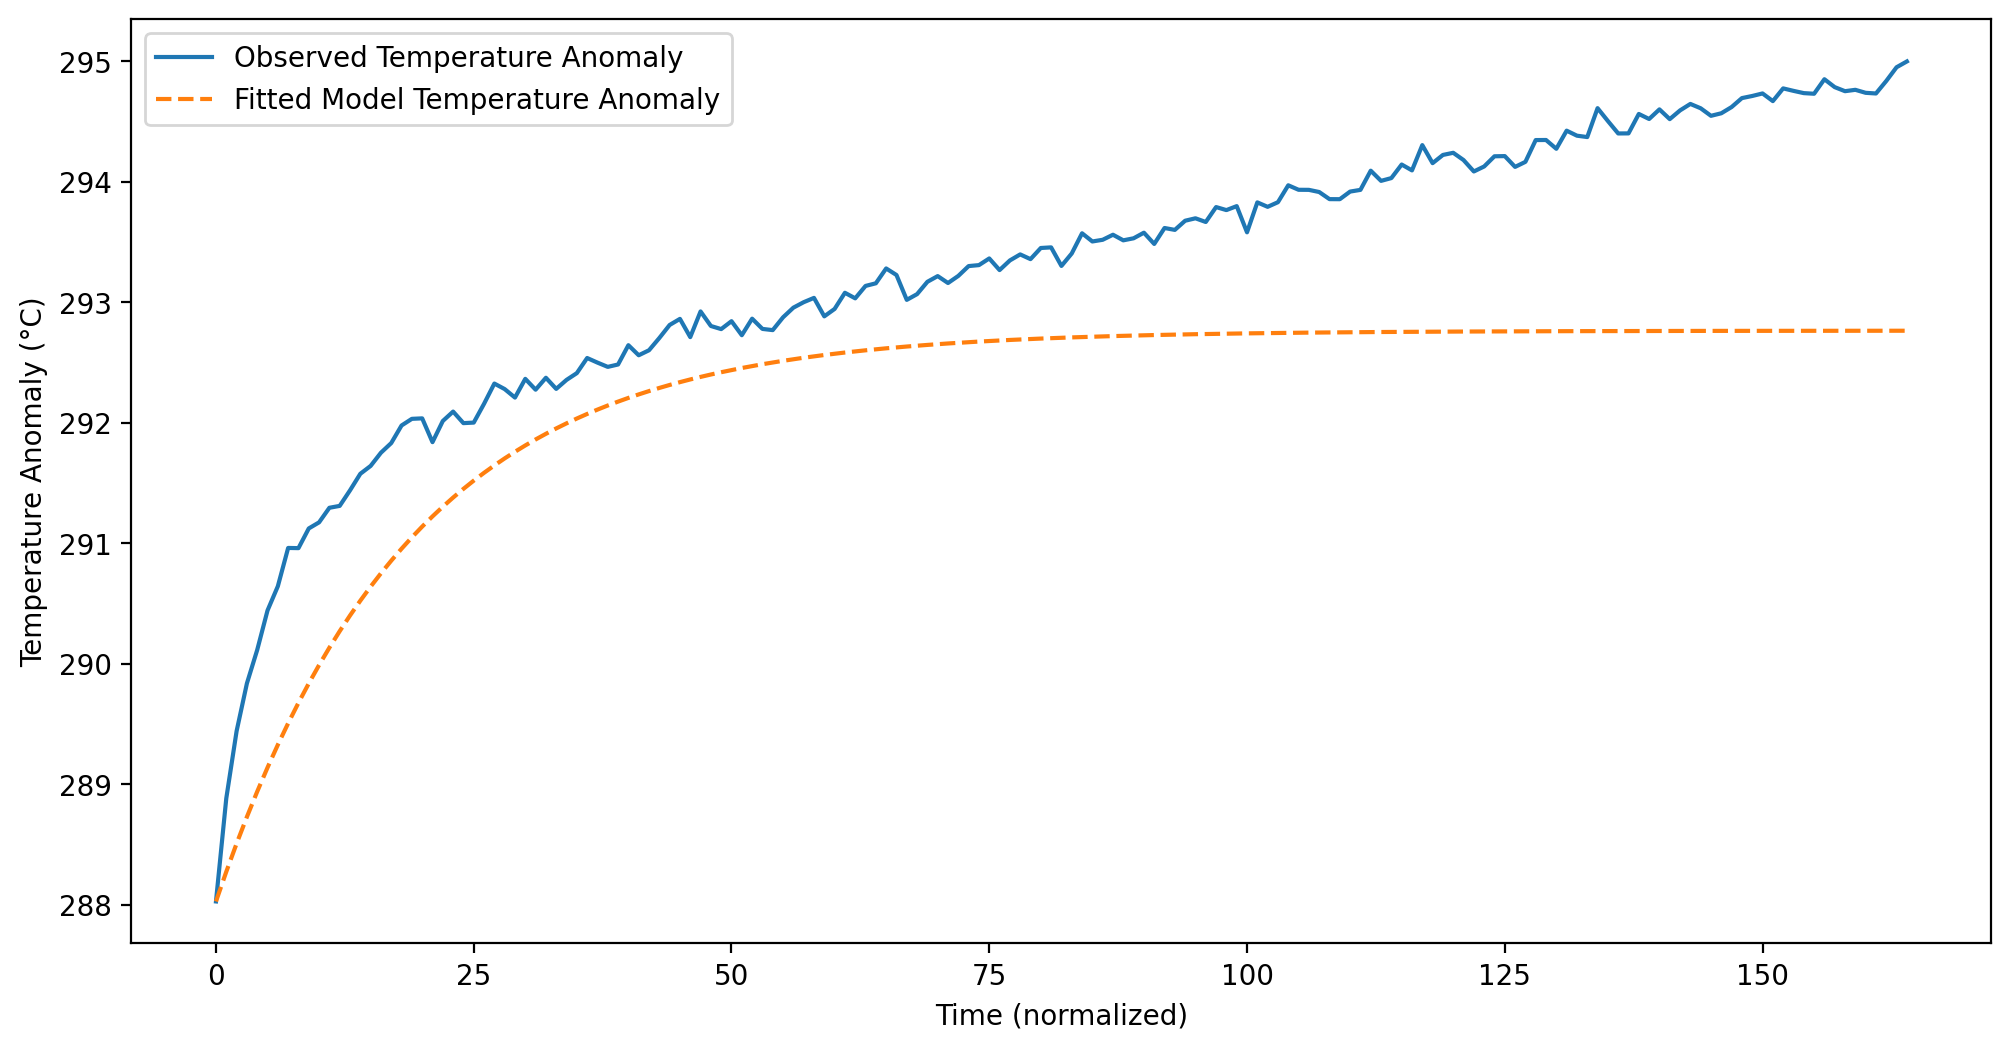

In [26]:
t = np.linspace(0, len(T) - 1, len(T))
C = 5.35
alpha, eps = alpha_over_C * C, epsilon_over_C * C
T_model = odeint(climate_model, T[0], t, args=(C, alpha, eps, calculate_forcing, CO2)).flatten()

# Plot the observed and fitted temperature anomaly
plt.plot(t, T + year_tas_ts[0], label='Observed Temperature Anomaly')
plt.plot(t, T_model + year_tas_ts[0], label='Fitted Model Temperature Anomaly', linestyle='--')
plt.xlabel('Time (normalized)')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

In [27]:
((48 + 51.5 + 49) / 150 * 40 + 87*0.3 - 93) / 0.3

-91.0